# 2. Communities, KNN, and Data Quality

In this notebook, you'll:
- Run KNN similarity and create relationships (K=25)
- Run Louvain community detection and assign community IDs
- Perform EDA on communities (size, median word length/count)
- Identify text chunk outliers
- Compute average similarity by community
- Identify and handle highly similar/duplicate nodes (with apoc.nodes.collapse)
- Discuss maintenance at scale


## 1. Run KNN on Similarity
We'll use the GDS KNN algorithm to find the 25 most similar nodes for each node based on their embeddings.


In [1]:
from neo4j import GraphDatabase
from graphdatascience import GraphDataScience
import os

NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USER = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))



def run_query(query, parameters=None):
    with driver.session() as session:
        return list(session.run(query, parameters or {}))
print('Connected to Neo4j!')

Connected to Neo4j!


## Projecting a KNN Graph with an Empty Relationship

To use the Neo4j GDS library for KNN, you must project a graph that includes both nodes and at least one relationship type. If your data does not have any existing relationships, you can create an empty relationship type as a placeholder.

### 1. Create an Empty Relationship Type

```python
run_query("""
CALL db.createRelationshipType('EMPTY')
""")
```

### 2. Project the Graph with the Empty Relationship

This projects an in-memory graph named docs with all Document nodes and their embedding property, using the empty EMPTY relationship type.

You can now use this projected graph for KNN or other GDS algorithms that require a relationship projection.


In [8]:
# create empty relationship type
run_query("""
CALL db.createRelationshipType('EMPTY')
""")

# project graph
run_query("""CALL gds.graph.project(
'docs',
    {
    Document: {
      properties: ['embedding']
    }
  },
  {
    EMPTY: {
      type: 'EMPTY',
      orientation: 'UNDIRECTED'
    }
  }
)
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount""")

[<Record graphName='docs' nodeCount=15292 relationshipCount=0>]

## Creating KNN Relationships Using Neo4j GDS

With our in-memory graph projected, we are ready to compute k-nearest neighbor (KNN) relationships between `Document` nodes. The KNN algorithm will compare node embeddings and identify the most similar nodes for each document.

Running the KNN algorithm will generate `SIMILAR` relationships between documents, with a similarity score stored as a relationship property. These relationships can then be used for downstream graph analytics, such as community detection or visualization.

In order to save workshop time, we will only mutate the rather than write as these have already been created in the db.

In [10]:
run_query("""
CALL gds.knn.stream('docs', {
  topK: 25,
  nodeProperties: ['embedding'],
  concurrency: 1
})
YIELD node1, node2, similarity
WITH gds.util.asNode(node1) AS doc1, gds.util.asNode(node2) AS doc2, similarity
MERGE (doc1)-[r:SIMILAR]->(doc2)
SET r.score = similarity
""")

[]

## 2. Community Detection and Assignment
We'll run Louvain community detection and assign a community ID to each node.


In [59]:
run_query("""
CALL gds.graph.project(
  'docs_community',
  {
    Document: {
      properties: ['embedding']
    }
  },
  {
    SIMILAR: {
      type: 'SIMILAR',
      orientation: 'UNDIRECTED',
      properties: {
        score: {
          property: 'score'
        }
      }
    }
  }
)
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
""")

[<Record graphName='docs_community' nodeCount=15292 relationshipCount=211086>]

## Community Detection with Louvain

Now that our documents are connected by `SIMILAR` relationships, we can use the Louvain algorithm to detect communities within the graph. This will assign a community ID to each document node, grouping similar documents together based on the structure of the graph.

In [63]:
run_query("""
CALL gds.louvain.write('docs_community', {
  writeProperty: 'community',
  relationshipTypes: ['SIMILAR'],
  relationshipWeightProperty: 'score'
})
YIELD communityCount, modularity, modularities
RETURN communityCount, modularity
""")

[<Record communityCount=37 modularity=0.8511544996331966>]

In [61]:
run_query("""
CALL gds.graph.project(
  'docs_scored',
  {
    Document: {
      properties: ['embedding']
    }
  },
  {
    SIMILAR: {
      type: 'SIMILAR',
      orientation: 'UNDIRECTED',
      properties: {
        score: {
          property: 'score'
        }
      }
    }
  }
)
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
""")

[<Record graphName='docs_scored' nodeCount=15292 relationshipCount=211086>]

In [64]:
run_query("""
MATCH (d:Document)
RETURN d.community AS community, count(*) AS size
ORDER BY size DESC
""")

[<Record community=8203 size=1306>,
 <Record community=15050 size=860>,
 <Record community=13929 size=823>,
 <Record community=13590 size=787>,
 <Record community=11583 size=783>,
 <Record community=12961 size=753>,
 <Record community=7561 size=736>,
 <Record community=5834 size=692>,
 <Record community=8863 size=658>,
 <Record community=14206 size=629>,
 <Record community=12564 size=628>,
 <Record community=10064 size=584>,
 <Record community=10822 size=506>,
 <Record community=3422 size=477>,
 <Record community=10791 size=456>,
 <Record community=14266 size=448>,
 <Record community=6496 size=438>,
 <Record community=8629 size=347>,
 <Record community=6236 size=318>,
 <Record community=6996 size=316>,
 <Record community=13401 size=301>,
 <Record community=13308 size=292>,
 <Record community=13020 size=279>,
 <Record community=3242 size=276>,
 <Record community=4861 size=254>,
 <Record community=8569 size=230>,
 <Record community=13265 size=190>,
 <Record community=11043 size=157>,
 <R

In [68]:
run_query("""
MATCH (d:Document)-[:HAS_CONTEXT]->(c:Chunk)-[:HAS_RATING]]->(r:Rating)
WHERE d.rating IS NOT NULL
WITH d.community AS community,
     count(*) AS total_responses,
     sum(CASE WHEN d.rating >= 4 THEN 1 ELSE 0 END) AS good_responses
RETURN community,
       total_responses,
       good_responses,
       toFloat(good_responses) / total_responses * 100 AS percent_good
ORDER BY percent_good DESC
""")

[]

In [75]:
import pandas as pd
context_df = pd.DataFrame(run_query('''
MATCH (d:Document)
RETURN
    d.index AS index,
    d.url AS url,
    d.text AS text
'''),columns=["index","url","text"])



In [76]:
context_df.head()

,index,url,text
0,6430,https://neo4j.com/docs/cypher-manual/current/s...,"For numerical values passed in as parameters, ..."
1,0,https://neo4j.com/docs/graph-data-science/curr...,Projecting graphs using Cypher (deprecated) Th...
2,1,https://neo4j.com/docs/graph-data-science/curr...,Using Legacy Cypher projections is a more flex...
3,2,https://neo4j.com/docs/graph-data-science/curr...,the Neo4j database management system is stoppe...
4,3,https://neo4j.com/docs/graph-data-science/curr...,2. Syntax A Legacy Cypher projection takes thr...


In [79]:
# download to new dataframe 
gds_df = pd.DataFrame(run_query('''
MATCH (d:Document)
RETURN 
    d.index AS index,
    d.community AS community,
    d.pageRank AS pageRank
'''),columns=["index","community","pageRank"])

gds_df.shape

(15292, 3)

In [80]:
gds_df.head()

,index,community,pageRank
0,6430,13590,0.181992
1,0,3422,0.335932
2,1,3422,0.360728
3,2,3422,0.473814
4,3,3422,0.982774


In [81]:
# merge gds values with context df
context_df = pd.merge(context_df, gds_df, on="index")
context_df.shape

(15292, 5)

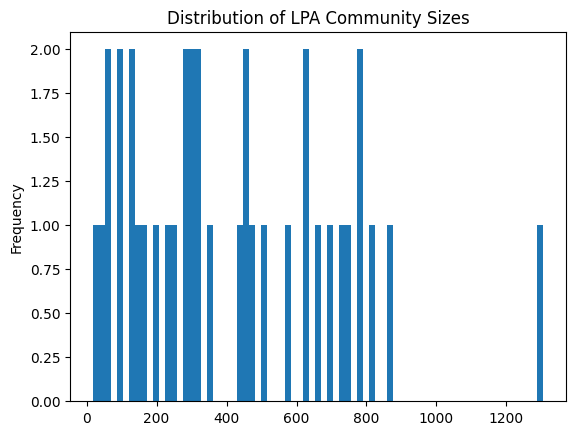

In [83]:
import matplotlib.pyplot as plt


context_df['community'].value_counts().plot(kind='hist', bins=75)
plt.title('Distribution of LPA Community Sizes')
plt.show()